In [47]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

from mutual_information import mutual_information_T_Y, mutual_information_X_T, mutual_information_T_C
from utils import light_blue, blue, orange, light_orange, green, light_green, \
    red, NO_CBM, NO_CBM_plus, CBM_bool, CBM_fuzzy, CBM_fuzzy_plus, \
    MaskedBoundedEmbedding, SplitEmbedding, name_mappings

os.listdir("results")

['old', 'trig_activation', 'vector_activation', 'xor_activation']

In [56]:
dataset = "trig"

result_folder = "results"
image_folder = "images"
trig_folder = "trig_activation"
data_folder = os.path.join(result_folder, trig_folder)

output_file = "test_embedding_vectors_on_epoch"

methods = [NO_CBM, CBM_bool, CBM_fuzzy, CBM_fuzzy_plus, SplitEmbedding]
methods_low_variance = methods[:4]
methods_high_variance = methods[-1:]

seeds = [*range(1, 6)]
epochs = [*range(100), *range(100, 3100, 25), 3100]

results\trig_activation\ConceptBottleneckModelNoConceptSupervisionReLU_fold_1: 100%|██████████| 221/221 [00:01<00:00, 204.23it/s]


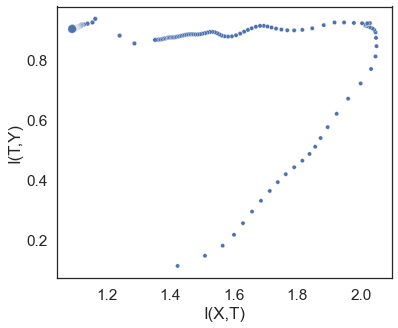

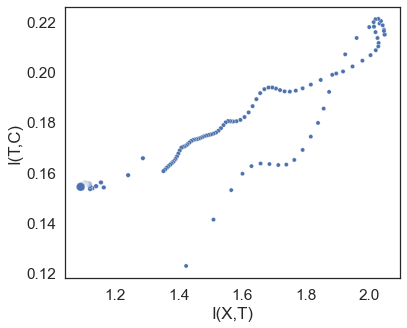

results\trig_activation\ConceptBottleneckModelBool_fold_1: 100%|██████████| 221/221 [00:01<00:00, 178.41it/s]


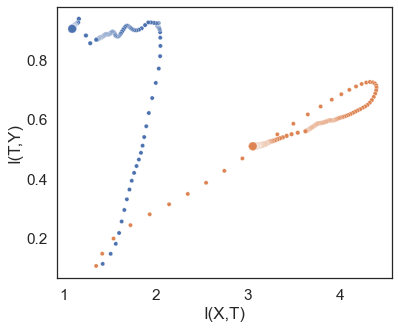

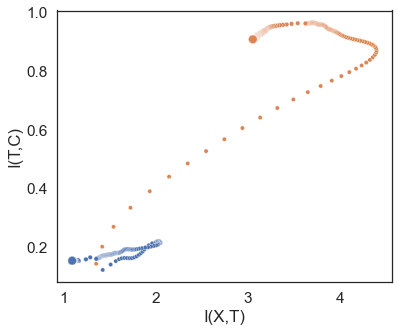

results\trig_activation\ConceptBottleneckModelFuzzy_fold_1: 100%|██████████| 221/221 [00:01<00:00, 211.04it/s]


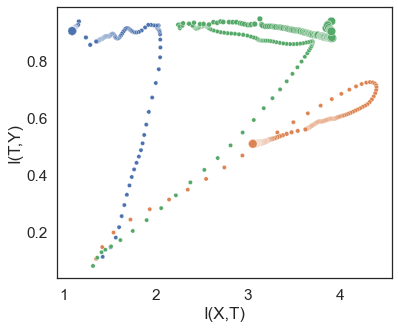

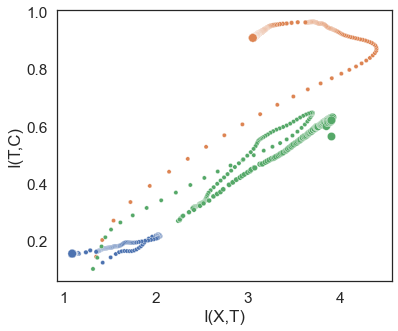

results\trig_activation\ConceptBottleneckModelFuzzyExtraCapacity_LogitOnlyExtra_fold_1: 100%|██████████| 221/221 [00:01<00:00, 187.95it/s]


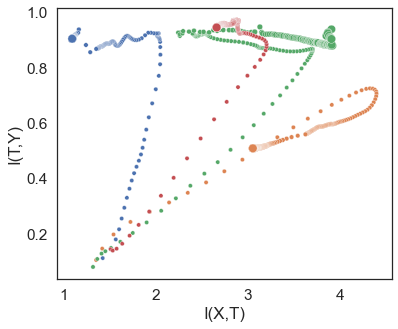

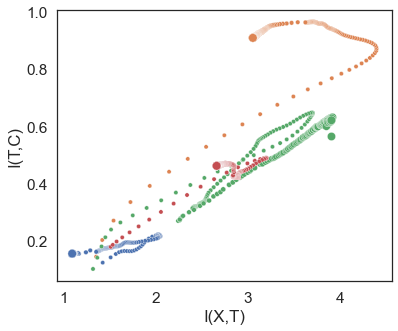

results\trig_activation\SplitEmbModelSharedProb_SigmoidalOnlyProb_fold_1: 100%|██████████| 221/221 [00:01<00:00, 188.97it/s]


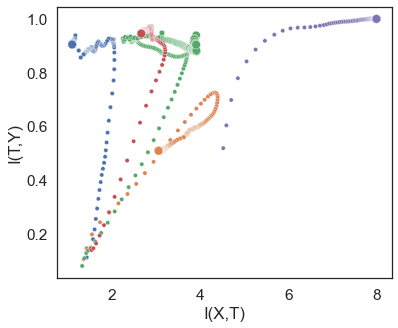

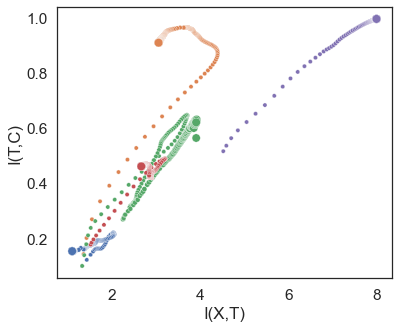

results\trig_activation\ConceptBottleneckModelNoConceptSupervisionReLU_fold_2: 100%|██████████| 221/221 [00:01<00:00, 215.00it/s]
results\trig_activation\ConceptBottleneckModelBool_fold_2: 100%|██████████| 221/221 [00:01<00:00, 212.46it/s]
results\trig_activation\ConceptBottleneckModelFuzzy_fold_2: 100%|██████████| 221/221 [00:01<00:00, 213.27it/s]
results\trig_activation\ConceptBottleneckModelFuzzyExtraCapacity_LogitOnlyExtra_fold_2: 100%|██████████| 221/221 [00:01<00:00, 197.50it/s]
results\trig_activation\SplitEmbModelSharedProb_SigmoidalOnlyProb_fold_2: 100%|██████████| 221/221 [00:01<00:00, 183.05it/s]
results\trig_activation\ConceptBottleneckModelNoConceptSupervisionReLU_fold_3: 100%|██████████| 221/221 [00:01<00:00, 204.04it/s]
results\trig_activation\ConceptBottleneckModelBool_fold_3: 100%|██████████| 221/221 [00:01<00:00, 196.01it/s]
results\trig_activation\ConceptBottleneckModelFuzzy_fold_3: 100%|██████████| 221/221 [00:01<00:00, 212.86it/s]
results\trig_activation\ConceptBot

In [57]:
labels_c = np.load(os.path.join(data_folder, "c_test.npy"), allow_pickle=True)
labels_y = np.load(os.path.join(data_folder, "y_test.npy"), allow_pickle=True)

debug = True
metrics = []
for seed in seeds:
    for method in methods:
        folder_name = os.path.join(data_folder, f"{method}_fold_{seed}")
        for epoch in tqdm(epochs, desc=folder_name):

            file = os.path.join(folder_name, f"{output_file}_{epoch}.npy")
            output = np.load(file, allow_pickle=True)

            N = output.shape[1]
#             noise_variance = N / 1000 if method in methods_low_variance else N/200
#             noise_variance = np.log(N)*2
            noise_variance = N/100

            MI_X_T, H_T, H_X_T = mutual_information_X_T(output,
                                                        return_H=True, noise_variance=noise_variance)
            MI_T_C, _, H_T_C  = mutual_information_T_C(output, labels_c, entropy_T=H_T,
                                                       return_H=True, noise_variance=noise_variance)
            MI_T_Y, _, H_T_Y = mutual_information_T_Y(output, labels_y, entropy_T=H_T,
                                                      return_H=True, noise_variance=noise_variance)

            # if epoch == 0:
                # assert MI_T_Y < 0.1, f"Error in computing at epoch 0 MI_T_Y: {MI_T_Y}"
                # assert MI_T_C < 0.1 or method in [NO_CBM, NO_CBM_plus], f"Error in computing at epoch 0 MI_T_Y: {MI_T_C}"

            epoch_metric = {
                "dataset": dataset,
                "method": method,
                "seed": seed,
                "epoch": epoch,
                "H(T)": H_T,
                "H(X|T)": H_X_T,
                "H(T|C)": H_T_C,
                "H(T|Y)": H_T_Y,
                "I(X,T)": MI_X_T,
                "I(T,C)": MI_T_C,
                "I(T,Y)": MI_T_Y,
            }
            metrics.append(epoch_metric)
            if debug == 2:
                print(f"\nH(T): {H_T:.2f}, H(X|T): {H_X_T:.2f}, H(T|C): {H_T_C:.2f}, H(T|Y): {H_T_Y:.2f}, "
                      f"I(X,T): {MI_X_T:.2f}, I(T,C): {MI_T_C:.2f}, I(T,Y): {MI_T_Y:.2f}")

        if seed == 1 and debug:
            df = pd.DataFrame(metrics)
            ax = sns.scatterplot(data=df, x="I(X,T)", y="I(T,Y)", size="epoch", hue="method")
            ax.legend().set_visible(False)
            plt.show()
            ax = sns.scatterplot(data=df, x="I(X,T)", y="I(T,C)", size="epoch", hue="method")
            ax.legend().set_visible(False)
            plt.show()

df = pd.DataFrame(metrics)
df.to_pickle(f"{dataset}_results.pkl")

In [58]:
df = pd.read_pickle(f"{dataset}_results.pkl")

if not os.path.isdir(image_folder):
    os.makedirs(image_folder)
# os.chdir(image_folder)

window = 100
df_mean = df.groupby(["dataset", "method", "epoch"]).mean().reset_index()

methods = []
for i, row in df_mean.iterrows():
    methods.append(name_mappings[row['method']])
df_mean['Methods'] = methods
# df_mean
methods = np.unique(np.asarray(methods)).tolist()
methods

['Bool', 'Fuzzy', 'Hybrid', 'Isolated Concept Embedding (ours)', 'No concepts']

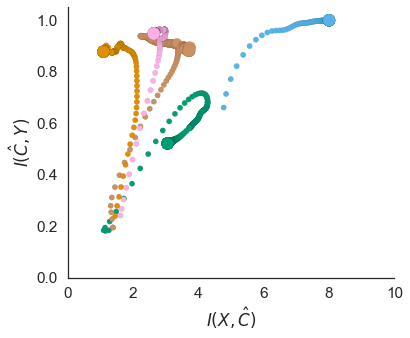

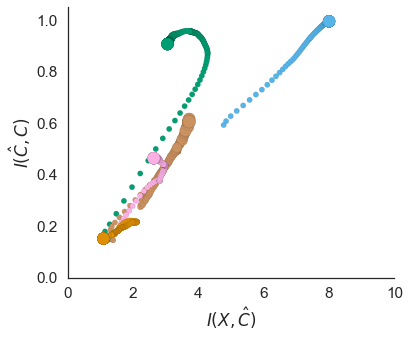

In [60]:
sns.set(style="white", rc={'figure.figsize': (6, 5)}, font_scale=1.4)
# params = {'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{fsmath}']}
# plt.rcParams.update(params)
# color_map = {
# #     'VanillaModel': clrs[0],
#     'VanillaModel': clrs[1],
#     'Bool': clrs[2],
#     'Fuzzy': clrs[5],
#     'Fuzzy+': clrs[6],
# #     'Masked Bounded Embedding': clrs[10],
#     'Concept Embedding': clrs[9],
# }
clrs = sns.color_palette("colorblind", 30)
palette = [clrs[2], clrs[5], clrs[6], clrs[1], clrs[9]]


ax = sns.scatterplot(data=df_mean, x="I(X,T)", y="I(T,Y)",
                     sizes=(30, 150), linewidth=0.05, edgecolor="black",
                hue="Methods", palette=palette, size="epoch")
ax.legend().set_visible(False)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.01,
#                  box.width, box.height * 0.99])
sns.despine()
plt.xlim((0, 10))
plt.ylim((0., 1.05))
plt.ylabel("$I(\hat{C}, Y)$")
plt.xlabel("$I(X, \hat{C})$")
# plt.legend(methods, loc="lower center", bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"{dataset}_plot_I(X,T)vsI(T,Y).png"), dpi=200)
plt.show()

ax = sns.scatterplot(data=df_mean, x="I(X,T)", y="I(T,C)",
                     sizes=(30, 150), linewidth=0.05, edgecolor="black",
                     hue="Methods", palette=palette,size="epoch")
ax.legend().set_visible(False)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.01,
#                  box.width, box.height * 0.99])
sns.despine()
plt.xlim((0, 10))
plt.ylim((0., 1.05))
plt.ylabel("$I(\hat{C}, C)$")
plt.xlabel("$I(X, \hat{C})$")
plt.tight_layout()
plt.savefig(os.path.join(image_folder, f"{dataset}_plot_I(X,T)vsI(T,C).png"), dpi=200)
plt.show()


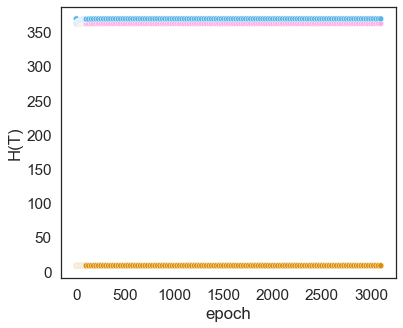

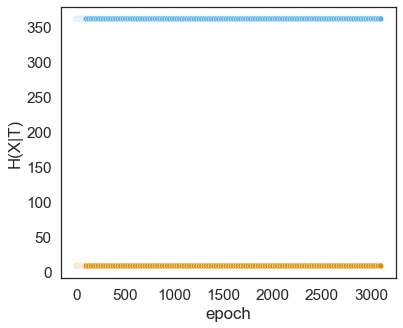

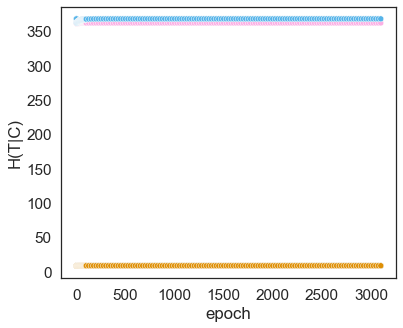

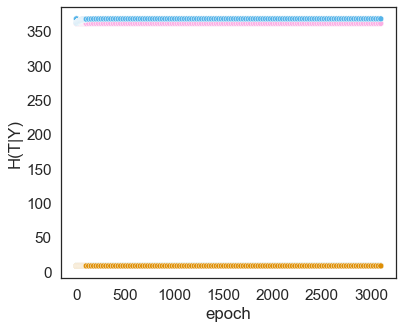

In [52]:
sns.scatterplot(data=df_mean, x="epoch", y="H(T)", hue="method", palette=palette, legend=False)
plt.savefig(os.path.join(image_folder, f"{dataset}_plot_H(T)"))
plt.show()
sns.scatterplot(data=df_mean, x="epoch", y="H(X|T)", hue="method", palette=palette, legend=False)
plt.savefig(os.path.join(image_folder, f"{dataset}_plot_H(T_X)"))
plt.show()
sns.scatterplot(data=df_mean, x="epoch", y="H(T|C)", hue="method", palette=palette, legend=False)
plt.savefig(os.path.join(image_folder, f"{dataset}_plot_H(T_C)"))
plt.show()
sns.scatterplot(data=df_mean, x="epoch", y="H(T|Y)", hue="method", palette=palette, legend=False)
plt.savefig(os.path.join(image_folder, f"{dataset}_plot_H(T_Y)"))
plt.show()